In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
#reading freesurfer results
out_dir = Path("/output")
fig_dir = out_dir / "figs"
fsdata_file = out_dir / 'freesurfer_out_preped.csv'
GROUPS  = ['PD','ET','NC']
tab_data = pd.read_csv(fsdata_file, sep=',', header=0, index_col=0);

# distribution of large brain parts ratio
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
tab_data=tab_data.drop(columns=drop_col_list);
for x in GROUPS:
    print(x , len(tab_data[tab_data["diagnosis"]==x]))

210708-20:07:41,876 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0
PD 42
ET 38
NC 32


In [2]:
# prepare target data
from matching.utils import sum_lr, ctr_age, ctr_conf, glm_test, sts_test, reformat_df
g_var_list  = ['age', 'sex', 'diagnosis', 'eTIV'];
s_var_list  = ['BrainSegVol','CSF','CerebralWhiteMatterVol','CortexVol', 'Brain_Stem', 'SubCortGrayVol', 'TotalGrayVol',
               'CC_Anterior','CC_Mid_Anterior','CC_Central','CC_Mid_Posterior','CC_Posterior',
               '3rd_Ventricle','4th_Ventricle','SupraTentorialVol'];
lr_var_list = ['Cerebellum_Cortex','Cerebellum_White_Matter',
               'Accumbens_area', 'Amygdala','Hippocampus',
               'Caudate', 'Pallidum', 'Putamen', 'Thalamus_Proper', 
               'Inf_Lat_Vent','Lateral_Ventricle'];
curr_data, curr_lr_list = sum_lr(tab_data, lr_var_list);

target_list = ['CSF','CerebralWhiteMatterVol','CortexVol', 'TotalGrayVol',
               'Brain_Stem', 'SubCortGrayVol', 
               'Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
               'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
               'Cerebellum_Cortex','Cerebellum_White_Matter'];

In [3]:
# removing confounders and effective size
### 
curr_data, rm_norm_list, rm_norm_reg = ctr_conf(
    curr_data, ['age', 'is_Male', 'eTIV'], target_list, 'rm_norm');

curr_data, pcp_list, pcp_reg = ctr_conf(curr_data, 'eTIV', target_list, 'ppa');

curr_data, dpa_list = ctr_conf(curr_data, 'eTIV', target_list, 'dpa');

curr_data, asm_list, asm_reg = ctr_conf(curr_data, 'eTIV', target_list, 'asm');
curr_data, rm_list, rm_reg = ctr_conf(curr_data, 'eTIV', target_list, 'rm_mean');

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from scipy.stats import ranksums
import pandas as pd
import numpy as np

n_permu=10000; alpha=5;
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p','method'];

In [4]:
## covariate
tar_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter']; # 'Cerebellum_Cortex','Cerebellum_White_Matter',
covariate_model_str = '~age+sex+eTIV+C(diagnosis, Treatment(reference="NC"))';
covariate_dict = glm_test(curr_data, tar_list, covariate_model_str);
covariate_df=sts_test(tar_list, curr_data, stats_cols, alpha, n_permu, 'covariate')
## dpa
dpa_list = [x+"_dpa" for x in tar_list ];
dpa_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
dpa_dict = glm_test(curr_data, dpa_list, dpa_model_str);
dpa_df=sts_test(dpa_list, curr_data, stats_cols, alpha, n_permu, 'dpa');
## ppa
ppa_list = [x+"_ppa" for x in tar_list ];
ppa_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
ppa_dict = glm_test(curr_data, ppa_list, ppa_model_str);
ppa_df=sts_test(ppa_list, curr_data, stats_cols, alpha, n_permu, 'ppa');
## rm_norm
rm_norm_list = [x+"_rm_norm" for x in tar_list ];
rm_norm_model_str = '~C(diagnosis, Treatment(reference="NC"))';
rm_norm_dict = glm_test(curr_data, rm_norm_list, rm_norm_model_str);
rm_norm_df=sts_test(rm_norm_list, curr_data, stats_cols, alpha, n_permu, 'rm_norm');
## rm_mean
rm_mean_list = [x+"_rm_mean" for x in tar_list];
rm_mean_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
rm_mean_dict = glm_test(curr_data, rm_mean_list, rm_mean_model_str);
rm_mean_df=sts_test(rm_mean_list, curr_data, stats_cols, alpha, n_permu, 'rm_mean');
## asm
asm_list = [x+"_asm" for x in tar_list];
asm_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
asm_dict = glm_test(curr_data, asm_list, asm_model_str);
asm_df   = sts_test(asm_list, curr_data, stats_cols, alpha, n_permu, 'asm');

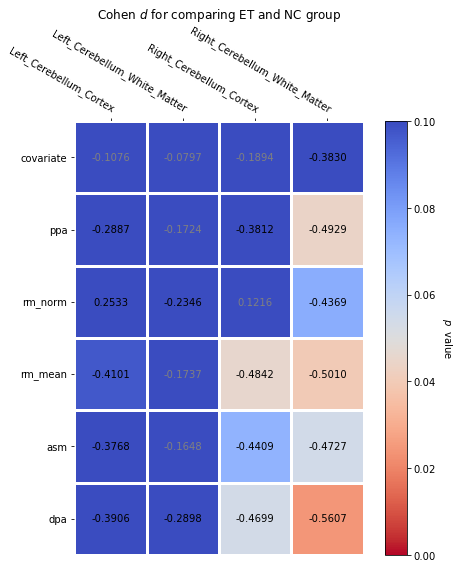

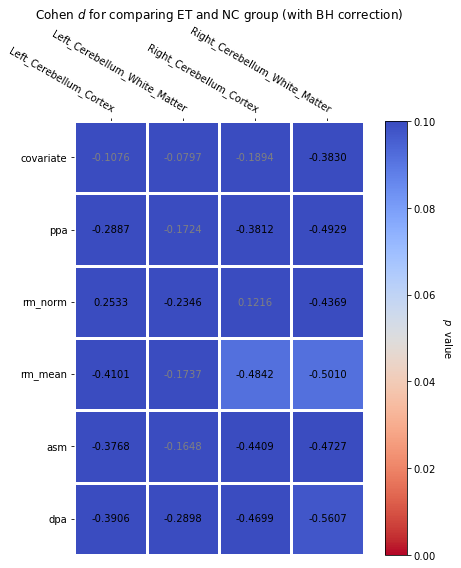

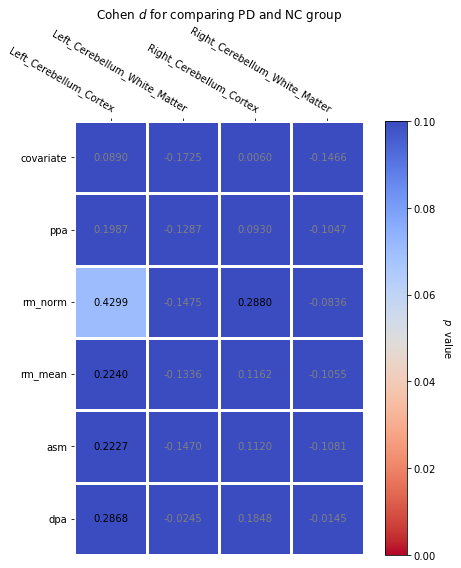

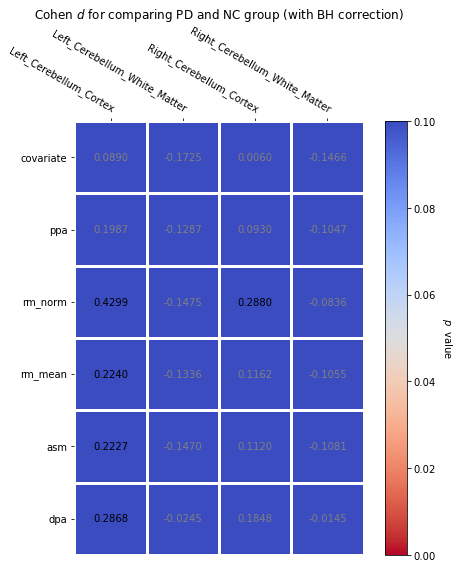

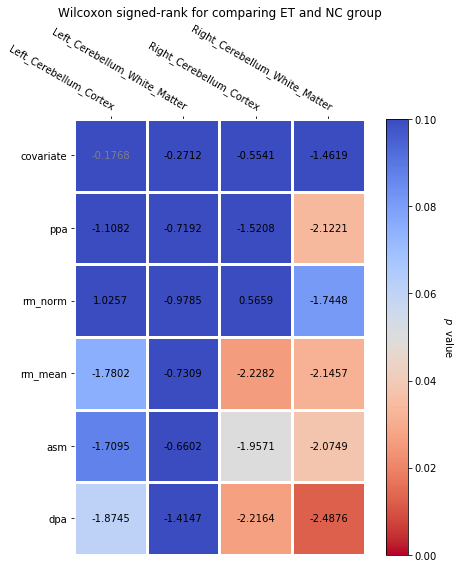

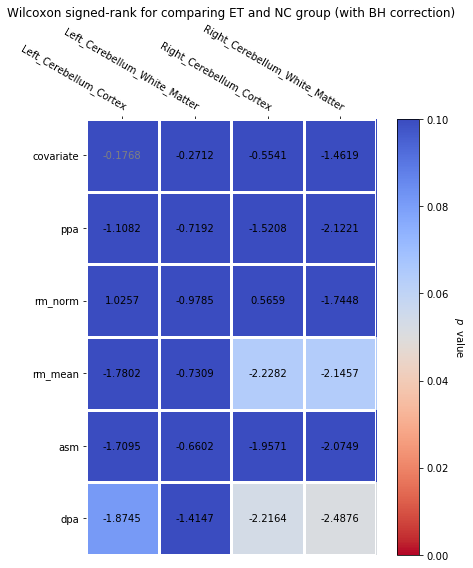

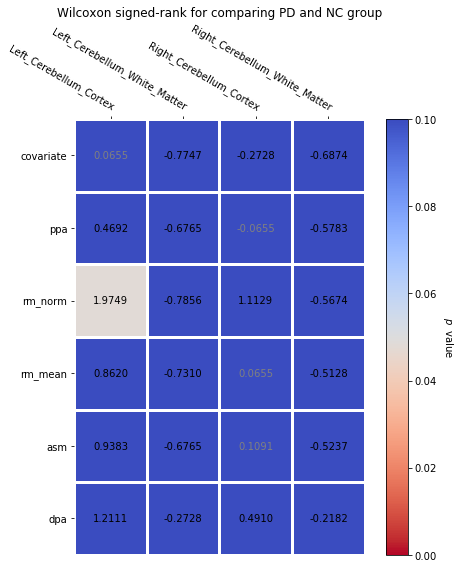

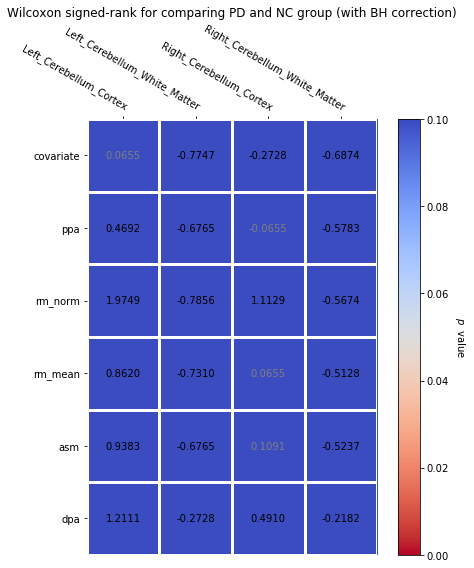

In [6]:
from matching.vis import heatmap, annotate_heatmap
def reformat_df(df, group_name, es_name):
    import statsmodels.stats as sts
    method_name=df['method'].unique();
    voi_name=df[df.method=='covariate']['voi'].unique();
    es_list=[]; p_list=[]; p_multi_list=[];
    for x in method_name:
        es_list_= list(df[(df['group']==group_name)&(df['method']==x)][es_name[0]]);
        p_list_ = list(df[(df['group']==group_name)&(df['method']==x)][es_name[1]]);
        p_multi_list_=sts.multitest.multipletests(p_list_, alpha=alpha/100,
                                                  method='fdr_bh', is_sorted=False, returnsorted=False)[1];
        es_list.append(es_list_); p_list.append(p_list_); p_multi_list.append(p_multi_list_);
    return es_list, p_list, p_multi_list, voi_name, method_name

##
sts_df = pd.DataFrame();
sts_df = sts_df.append(covariate_df.append(ppa_df.append(rm_norm_df.append(rm_mean_df.append(asm_df.append(dpa_df, ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True)

et_es, et_p, p_multi_et, voi_name, method_name = reformat_df(sts_df, 'ETNC', ['cohen_d', 'cohen_p']);
pd_es, pd_p, p_multi_pd, voi_name, method_name = reformat_df(sts_df, 'PDNC', ['cohen_d', 'cohen_p']);

et_wil, et_wp, wp_multi_et, voi_name, method_name = reformat_df(sts_df, 'ETNC', ['Wilcoxon', 'Wilcoxon_p']);
pd_wil, pd_wp, wp_multi_pd, voi_name, method_name = reformat_df(sts_df, 'PDNC', ['Wilcoxon', 'Wilcoxon_p']);

#method_name = ['Voi','DPA','PPA','RM-Norm', 'RM-Mean','Allometric Scaling']

import numpy as np
import matplotlib.pyplot as plt
def plot_effectsize(et_es, et_p, p_multi_et, NAME):
    #et_es=et_es[0]; et_p=et_p[0]; p_multi_et=p_multi_et[0];
    import matplotlib.pyplot as plt
    VMIN = 0; VMAX=0.1; C_MAP='coolwarm_r'; es_th = 0.2; f_size=[7,8];
    fig1=plt.figure(figsize=f_size); ax1 = fig1.subplots();
    im1, cbar1 = heatmap(np.array(et_p), method_name, voi_name, ax=ax1, cmap=C_MAP, cbarlabel="$p$  value", vmin=VMIN, vmax=VMAX)
    texts = annotate_heatmap(im1, np.array(et_es), valfmt="{x:.4f}", textcolors=["grey", "black"], threshold=es_th)
    ax1.set_title(NAME); fig1.tight_layout(); plt.show()
    fig2=plt.figure(figsize=f_size); ax2 = fig2.subplots();
    im2, cbar2 = heatmap(np.array(p_multi_et), method_name, voi_name, ax=ax2, cmap=C_MAP,cbarlabel="$p$  value", vmin=VMIN, vmax=VMAX)
    texts = annotate_heatmap(im2, np.array(et_es), valfmt="{x:.4f}", textcolors=["grey", "black"], threshold=es_th)
    ax2.set_title(NAME+' (with BH correction)'); fig2.tight_layout(); plt.show()
    return ax1, ax2

ax1_et_coh, ax2_et_coh = plot_effectsize(et_es, et_p, p_multi_et, 'Cohen $d$ for comparing ET and NC group')
ax1_pd_coh, ax2_pd_coh = plot_effectsize(pd_es, pd_p, p_multi_pd, 'Cohen $d$ for comparing PD and NC group')
ax1_et_wil, ax2_et_wil = plot_effectsize(et_wil, et_wp, wp_multi_et, 'Wilcoxon signed-rank for comparing ET and NC group')
ax1_pd_wil, ax2_pd_wil = plot_effectsize(pd_wil, pd_wp, wp_multi_pd, 'Wilcoxon signed-rank for comparing PD and NC group')


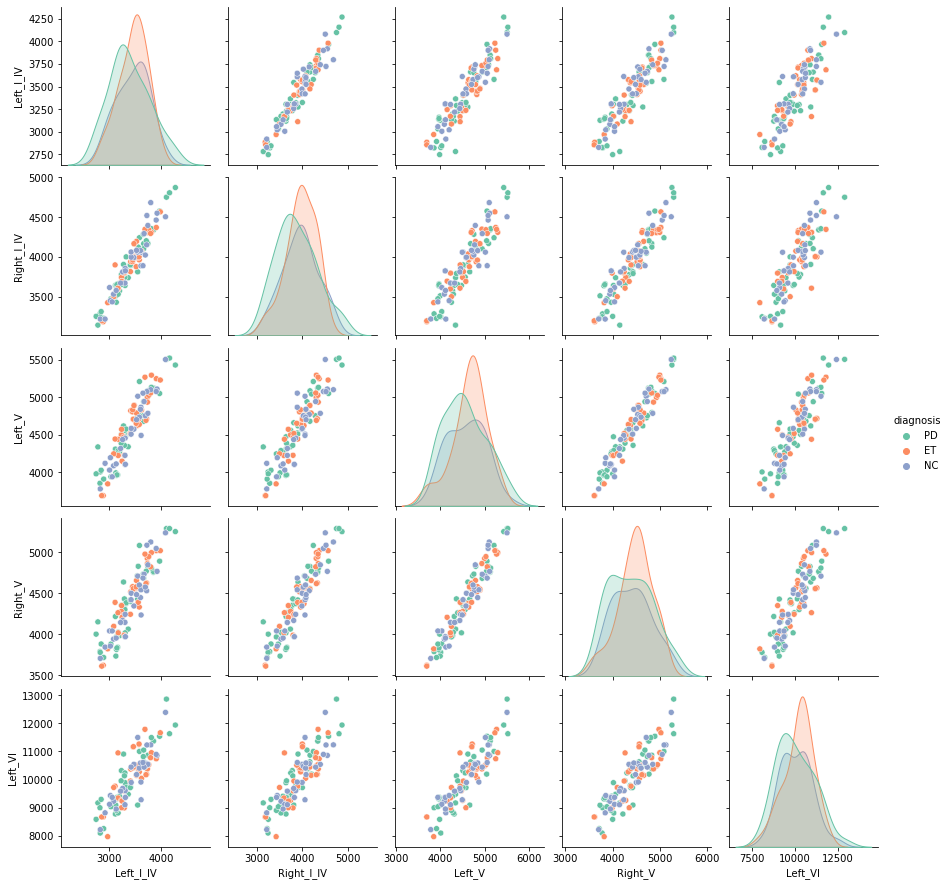

In [7]:
import seaborn as sns
mdtb_labels = ['MDTB_'+str(x+1) for x in range(10)];
suit_labels = ['Left_I_IV', 'Right_I_IV', 'Left_V', 'Right_V', 'Left_VI', 'Vermis_VI',
               'Right_VI', 'Left_CrusI', 'Vermis_CrusI', 'Right_CrusI', 'Left_CrusII',
               'Vermis_CrusII', 'Right_CrusII', 'Left_VIIb', 'Vermis_VIIb',
               'Right_VIIb', 'Left_VIIIa', 'Vermis_VIIIa', 'Right_VIIIa', 'Left_VIIIb',
               'Vermis_VIIIb', 'Right_VIIIb', 'Left_IX', 'Vermis_IX', 'Right_IX',
               'Left_X', 'Vermis_X', 'Right_X', 'Left_Dentate', 'Right_Dentate',
               'Left_Interposed', 'Right_Interposed', 'Left_Fastigial','Right_Fastigial'];
t1=sns.pairplot(curr_data, vars=suit_labels[:5],  hue="diagnosis", palette="Set2",
                diag_kind="kde", height=2.5)

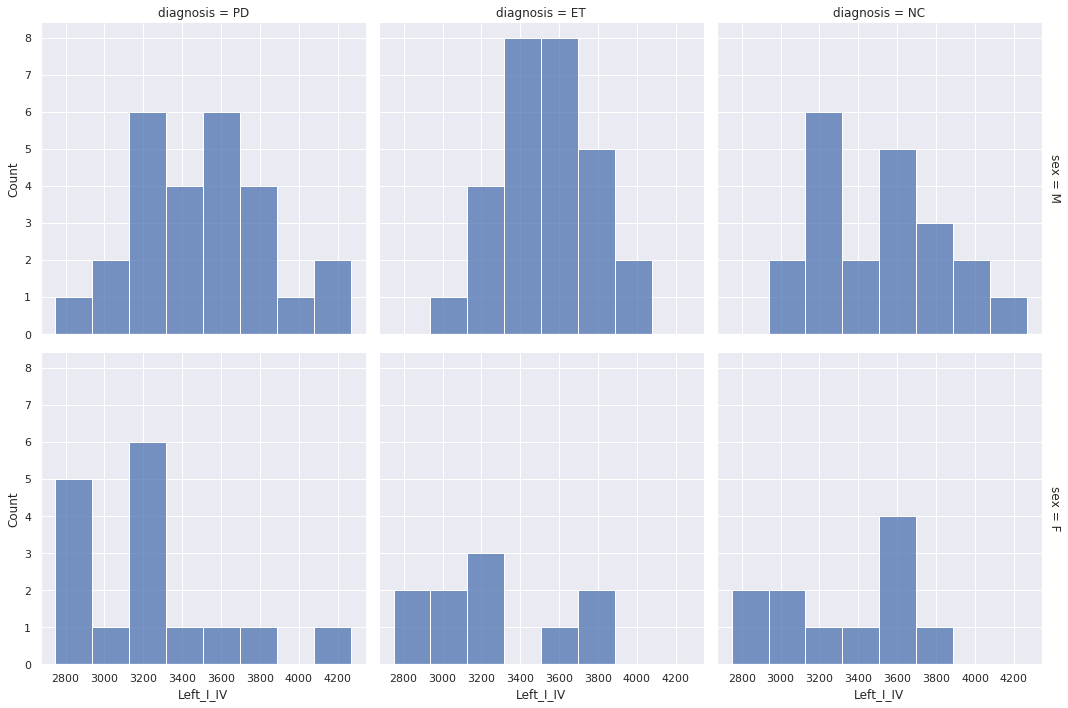

In [9]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.displot(
    curr_data, x="Left_I_IV", col="diagnosis", row="sex", facet_kws=dict(margin_titles=True))

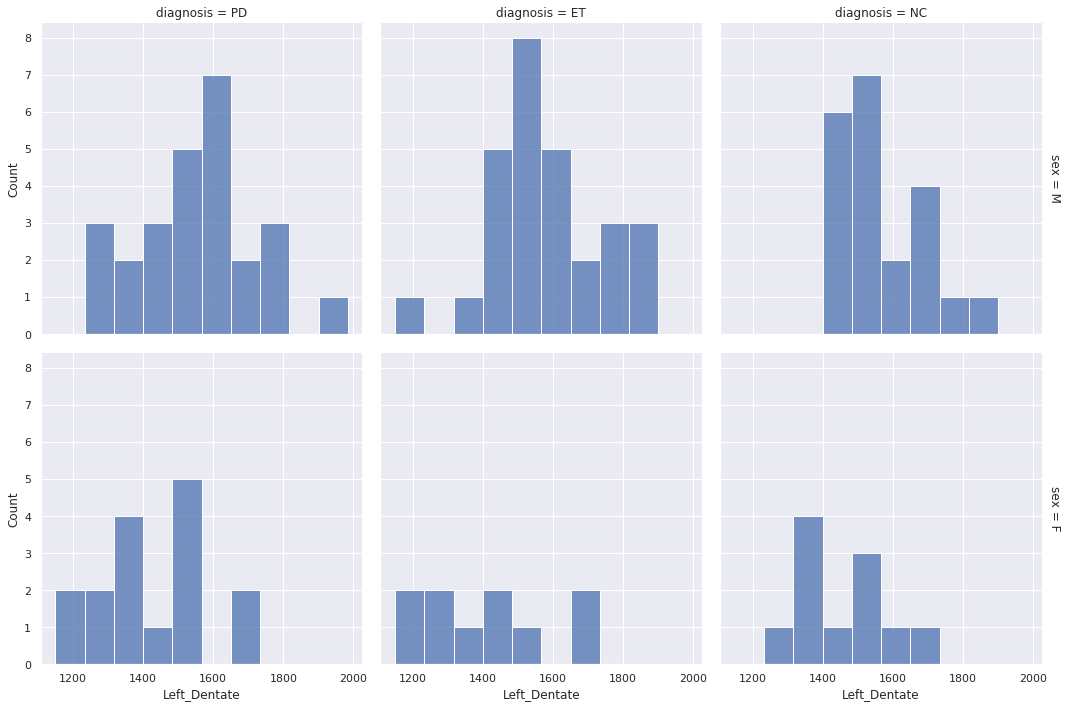

In [10]:
sns.displot(
    curr_data, x="Left_Dentate", col="diagnosis", row="sex", facet_kws=dict(margin_titles=True))

In [11]:
import statsmodels.stats as sts
sts.multitest.multipletests(sts_df[sts_df['group']=='ETNC']['Wilcoxon_p'], alpha=0.05,
                            method='fdr_bh', is_sorted=False, returnsorted=False)
sts_df['method'].unique()

array(['covariate', 'ppa', 'rm_norm', 'rm_mean', 'asm', 'dpa'],
      dtype=object)

/usr/local/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


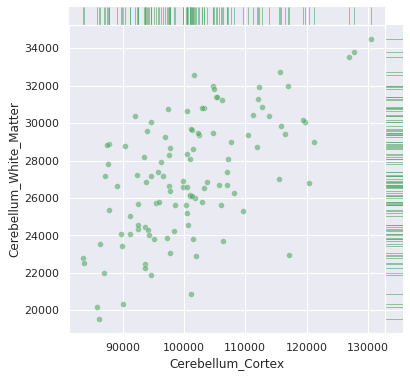

In [13]:
#distribution
g = sns.JointGrid(data=tab_data, x="Cerebellum_Cortex", y="Cerebellum_White_Matter", space=0, ratio=17)
g.plot_joint(sns.scatterplot,
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g",alpha=.6)
                 

In [15]:
import statsmodels
statsmodels.__version__

'0.12.0'